# Mon-Reader: Detecting Page Flipping, Text Extraction, and Speech Synthesis
This notebook covers the following workflow:
1. **Detect page flipping vs. still pages using CNNs** (ResNet, MobileNet, EfficientNet, and a custom Osama Net) on the provided image dataset.
2. **Extract text from detected still page frames** (future step, not implemented in this notebook).
3. **Synthesize speech from extracted text (TTS)** (future step, not implemented in this notebook).

## Notebook Outline
- Import Required Libraries (with GPU support)
- Load and Preprocess Dataset (images/training and images/testing, with flip/notflip subfolders)
- Prepare Data Generators (with augmentation)
- Build and Evaluate ResNet Model
- Build and Evaluate MobileNet Model
- Build and Evaluate EfficientNet Model
- Define and Train Custom CNN (Osama Net)
- Evaluate Osama Net on Test Set and Show Predictions
- Compare Model Accuracies and Analysis

# 1. Import Required Libraries and Enable GPU Support

In this section, we import PyTorch and check for GPU availability. PyTorch will automatically use the GPU when available, which significantly speeds up model training.

## CPU vs GPU Tips:
- **GPU Acceleration**: Deep learning models train much faster on GPU than CPU.
- **Device Selection**: We use `torch.device()` to automatically select GPU when available.
- **Memory Management**: 
  - For large models, use smaller batch sizes on GPU with limited memory
  - Use `pin_memory=True` for faster GPU data transfers
  - Call `model.to(device)` to move the model to GPU/CPU
  - Ensure tensors are on the same device with `.to(device)`
- **Switching Between Devices**: To switch between CPU/GPU, just change the device variable and move tensors accordingly

In [6]:
import torch
import torchvision

print(torch.__version__)
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2.7.1+cu128
CUDA available: True
Using device: cuda


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import random
from torch import nn, optim
from torchvision import models
from torch.optim import Adam
from torch.utils.data.sampler import SubsetRandomSampler

# 2. Load and Preprocess Dataset

Here we define our image size and batch size parameters, and load the training and testing datasets from their respective directories. The dataset has two classes: 'flip' and 'notflip'.

In [8]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dir = "images/training"
test_dir = "images/testing"

transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
    ]
)

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['flip', 'notflip']


# 3. Prepare Data Generators with Augmentation

Data augmentation helps prevent overfitting by creating variations of our training images. 
This is especially important for smaller datasets. The transformations include:
- Random horizontal flipping
- Random rotation (up to 10 degrees)
- Random affine transformations (translation and scaling)

In [9]:
aug_transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
    ]
)

aug_train_dataset = ImageFolder(root=train_dir, transform=aug_transform)
aug_train_loader = DataLoader(aug_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4. Build and Evaluate Models

## Using BCEWithLogitsLoss Instead of BCELoss

In our updated models, we'll use `BCEWithLogitsLoss` instead of `BCELoss` for the following reasons:

1. **Numerical Stability**: BCEWithLogitsLoss combines sigmoid and binary cross-entropy in one operation, which is more numerically stable.

2. **Performance**: It's more efficient, especially on GPU, since it can leverage optimized implementations.

3. **Avoiding Vanishing Gradients**: By incorporating the sigmoid operation, it prevents extreme values that could lead to vanishing gradients.

4. **Simplified Model Architecture**: We can remove the final Sigmoid layer from our models, as BCEWithLogitsLoss applies it internally.

All of our models will output raw logits rather than probabilities, with the loss function handling the sigmoid transformation.

## ResNet Model

Loading resnet_model from saved_models/resnet_model.pth
ResNet Test Accuracy: 0.7136
ResNet Test Accuracy: 0.7136


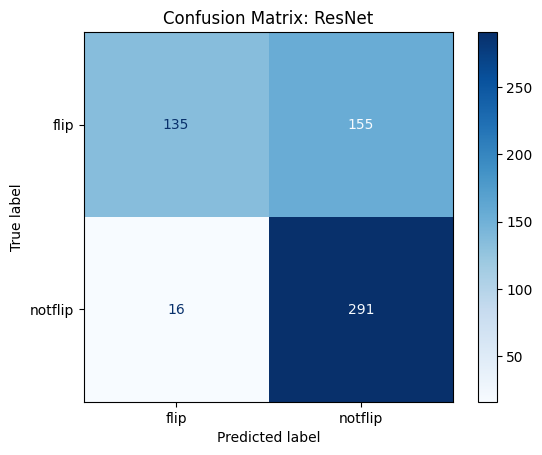

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.optim import Adam
from torchvision import models


def build_resnet(num_classes=1):
    model = models.resnet50(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )
    return model


def train_or_load_model(
    model, model_name, train_loader, test_loader, device, epochs=10, optimizer_cls=Adam
):
    os.makedirs("saved_models", exist_ok=True)
    model_path = f"saved_models/{model_name}.pth"
    if os.path.exists(model_path):
        print(f"Loading {model_name} from {model_path}")
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        return model
    print(f"Training {model_name}...")
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optimizer_cls(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            labels = labels.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.float().to(device)
                labels = labels.unsqueeze(1)
                outputs = model(images)
                preds = (outputs > 0).int()
                correct += (preds == labels.int()).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Test Accuracy: {acc:.4f}")
    torch.save(model.state_dict(), model_path)
    print(f"Saved {model_name} to {model_path}")
    return model


def evaluate_model(model, test_loader, device, class_names, model_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device)
            outputs = model(images)
            preds = (outputs > 0).int().cpu().numpy().flatten()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().flatten())
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"{model_name} Test Accuracy: {acc:.4f}")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()
    return acc


# ResNet
resnet_model = build_resnet()
resnet_model = train_or_load_model(
    resnet_model, "resnet_model", aug_train_loader, test_loader, device, epochs=10
)
resnet_acc = evaluate_model(resnet_model, test_loader, device, class_names, "ResNet")

# 5. Build and Evaluate MobileNet Model

MobileNet is a lightweight CNN architecture designed for mobile and embedded vision applications.
It's significantly smaller than ResNet while still providing good accuracy.

Training mobilenet_model...
Epoch 1/10, Test Accuracy: 0.7236
Epoch 1/10, Test Accuracy: 0.7236
Epoch 2/10, Test Accuracy: 0.7588
Epoch 2/10, Test Accuracy: 0.7588
Epoch 3/10, Test Accuracy: 0.8258
Epoch 3/10, Test Accuracy: 0.8258
Epoch 4/10, Test Accuracy: 0.8325
Epoch 4/10, Test Accuracy: 0.8325
Epoch 5/10, Test Accuracy: 0.8459
Epoch 5/10, Test Accuracy: 0.8459
Epoch 6/10, Test Accuracy: 0.8626
Epoch 6/10, Test Accuracy: 0.8626
Epoch 7/10, Test Accuracy: 0.8626
Epoch 7/10, Test Accuracy: 0.8626
Epoch 8/10, Test Accuracy: 0.8660
Epoch 8/10, Test Accuracy: 0.8660
Epoch 9/10, Test Accuracy: 0.8643
Epoch 9/10, Test Accuracy: 0.8643
Epoch 10/10, Test Accuracy: 0.8693
Saved mobilenet_model to saved_models/mobilenet_model.pth
Epoch 10/10, Test Accuracy: 0.8693
Saved mobilenet_model to saved_models/mobilenet_model.pth
MobileNet Test Accuracy: 0.8693
MobileNet Test Accuracy: 0.8693


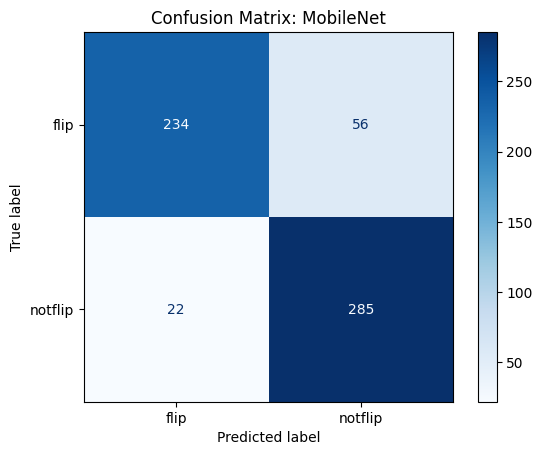

MobileNet Test Accuracy: 0.8693


In [11]:
def build_mobilenet(num_classes=1):
    model = models.mobilenet_v2(weights="IMAGENET1K_V1")
    # Freeze all the parameters in the pre-trained model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier with a new one
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
        # No sigmoid - using BCEWithLogitsLoss
    )
    return model


# Build the MobileNet model
mobilenet_model = build_mobilenet()

# Train the model
mobilenet_model = train_or_load_model(
    mobilenet_model, "mobilenet_model", aug_train_loader, test_loader, device, epochs=10
)

# Evaluate the model
mobilenet_acc = evaluate_model(
    mobilenet_model, test_loader, device, class_names, "MobileNet"
)

# Print the final accuracy
print(f"MobileNet Test Accuracy: {mobilenet_acc:.4f}")


# 6. Build and Evaluate EfficientNet Model

EfficientNet uses a compound scaling method that uniformly scales network width, depth, and resolution
to balance model size and accuracy. It's known for achieving state-of-the-art accuracy with fewer parameters.

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\Osama/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100.0%



Training efficientnet_model...
Epoch 1/10, Test Accuracy: 0.7186
Epoch 1/10, Test Accuracy: 0.7186
Epoch 2/10, Test Accuracy: 0.7504
Epoch 2/10, Test Accuracy: 0.7504
Epoch 3/10, Test Accuracy: 0.8007
Epoch 3/10, Test Accuracy: 0.8007
Epoch 4/10, Test Accuracy: 0.8241
Epoch 4/10, Test Accuracy: 0.8241
Epoch 5/10, Test Accuracy: 0.8124
Epoch 5/10, Test Accuracy: 0.8124
Epoch 6/10, Test Accuracy: 0.8459
Epoch 6/10, Test Accuracy: 0.8459
Epoch 7/10, Test Accuracy: 0.8459
Epoch 7/10, Test Accuracy: 0.8459
Epoch 8/10, Test Accuracy: 0.8576
Epoch 8/10, Test Accuracy: 0.8576
Epoch 9/10, Test Accuracy: 0.8509
Epoch 9/10, Test Accuracy: 0.8509
Epoch 10/10, Test Accuracy: 0.8409
Saved efficientnet_model to saved_models/efficientnet_model.pth
Epoch 10/10, Test Accuracy: 0.8409
Saved efficientnet_model to saved_models/efficientnet_model.pth
EfficientNet Test Accuracy: 0.8409
EfficientNet Test Accuracy: 0.8409


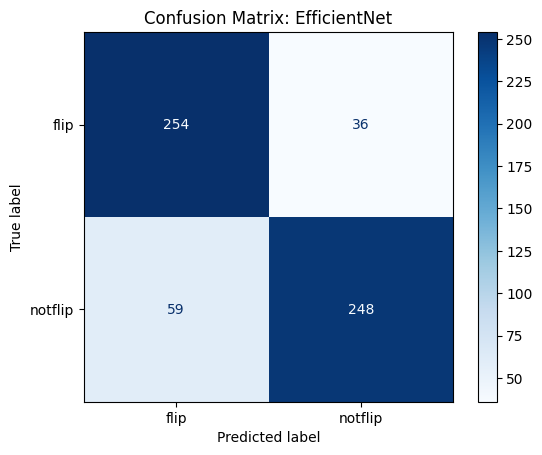

In [12]:
def build_efficientnet(num_classes=1):
    model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(model.classifier[1].in_features, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes),
    )
    return model


efficientnet_model = build_efficientnet()
efficientnet_model = train_or_load_model(
    efficientnet_model,
    "efficientnet_model",
    aug_train_loader,
    test_loader,
    device,
    epochs=10,
)
efficientnet_acc = evaluate_model(
    efficientnet_model, test_loader, device, class_names, "EfficientNet"
)

# 7. Define and Train Custom CNN (Osama Net)

Here we define a custom CNN architecture called "Osama Net" with three convolutional blocks
followed by a classifier with dropout for regularization.

Training osama_net...
Epoch 1/20, Test Accuracy: 0.5896
Epoch 1/20, Test Accuracy: 0.5896
Epoch 2/20, Test Accuracy: 0.8978
Epoch 2/20, Test Accuracy: 0.8978
Epoch 3/20, Test Accuracy: 0.9531
Epoch 3/20, Test Accuracy: 0.9531
Epoch 4/20, Test Accuracy: 0.9732
Epoch 4/20, Test Accuracy: 0.9732
Epoch 5/20, Test Accuracy: 0.9497
Epoch 5/20, Test Accuracy: 0.9497
Epoch 6/20, Test Accuracy: 0.9481
Epoch 6/20, Test Accuracy: 0.9481
Epoch 7/20, Test Accuracy: 0.6851
Epoch 7/20, Test Accuracy: 0.6851
Epoch 8/20, Test Accuracy: 0.9313
Epoch 8/20, Test Accuracy: 0.9313
Epoch 9/20, Test Accuracy: 0.9414
Epoch 9/20, Test Accuracy: 0.9414
Epoch 10/20, Test Accuracy: 0.9045
Epoch 10/20, Test Accuracy: 0.9045
Epoch 11/20, Test Accuracy: 0.9581
Epoch 11/20, Test Accuracy: 0.9581
Epoch 12/20, Test Accuracy: 0.9715
Epoch 12/20, Test Accuracy: 0.9715
Epoch 13/20, Test Accuracy: 0.9497
Epoch 13/20, Test Accuracy: 0.9497
Epoch 14/20, Test Accuracy: 0.9414
Epoch 14/20, Test Accuracy: 0.9414
Epoch 15/20, Tes

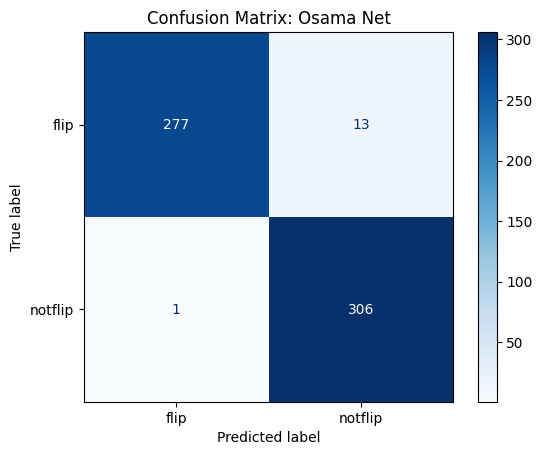

In [13]:
from lion_pytorch import Lion


class OsamaNet(nn.Module):
    def __init__(self, num_classes=1):
        super(OsamaNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


osama_net = OsamaNet()
osama_net = train_or_load_model(
    osama_net,
    "osama_net",
    aug_train_loader,
    test_loader,
    device,
    epochs=20,
    optimizer_cls=Lion,
)
osama_acc = evaluate_model(osama_net, test_loader, device, class_names, "Osama Net")

# 8. Evaluate Models and Compare Results

Finally, we evaluate our models on the test dataset and visualize some predictions.
We also compare the performance of all models to identify the best architecture for our task.

ResNet Test Accuracy: 0.7136
MobileNet Test Accuracy: 0.8693
EfficientNet Test Accuracy: 0.8409
Osama Net Test Accuracy: 0.9765

MobileNet Test Accuracy: 0.8693
EfficientNet Test Accuracy: 0.8409
Osama Net Test Accuracy: 0.9765


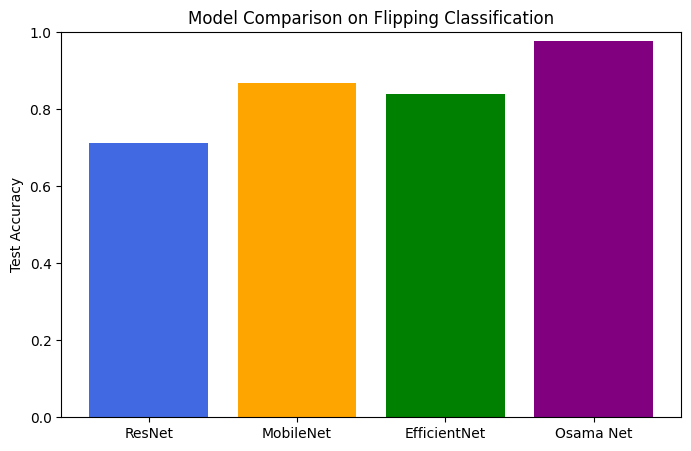

Analysis:
Compare the results above. The best model is the one with the highest test accuracy. Consider model complexity, training time, and overfitting when choosing the best architecture for this task.


In [14]:
# Compare Model Accuracies and Analysis
print(f"ResNet Test Accuracy: {resnet_acc:.4f}")
print(f"MobileNet Test Accuracy: {mobilenet_acc:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_acc:.4f}")
print(f"Osama Net Test Accuracy: {osama_acc:.4f}")

accuracies = [resnet_acc, mobilenet_acc, efficientnet_acc, osama_acc]
model_names = ["ResNet", "MobileNet", "EfficientNet", "Osama Net"]
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=["royalblue", "orange", "green", "purple"])
plt.ylabel("Test Accuracy")
plt.title("Model Comparison on Flipping Classification")
plt.ylim(0, 1)
plt.show()

# Analysis
print("Analysis:")
print(
    "Compare the results above. The best model is the one with the highest test accuracy. Consider model complexity, training time, and overfitting when choosing the best architecture for this task."
)